# Kaggle: Housing Prices

Kaggle housing prices challenge in Julia.  
This is an attempt to complete the kaggle housing prices challenge, described [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data), with the Julia language.

I do not have any experience with Julia, so I'm relying on tutorials that can be found on [JuliaBox](https://juliabox.com/) to guide me in data processing, plotting, and analysis ([here](https://github.com/JuliaComputing/JuliaBoxTutorials/blob/master/introductory-tutorials/broader-topics-and-ecosystem) they are on GitHub).  
This will mirror other work that I have tried for this challenge that uses Python (with which I'm much more familiar).

This notebook is a continuation of the notebooks featured in the figment `python/` directory.  Here, we explore the same Kaggle [challenge](https://www.kaggle.com/c/house-prices-advanced-regression-techniques),
but we are using `Julia` instead of `python`!

I'll refer you to the python notebooks for the exploratory analysis.  For this notebook, I will mostly be playing around with `Julia` (trying to learn it) and specifically, the `Flux` module.

_When it occurs, I will try to put links to blogs/stackoverflow for code I need to lookup_

To get started, let's clone the repository into JuliaBox so that we have access to the data.

_Using the 'terminal' from JuliaBox, it is possible to clone the repository into your account and then work from the notebook within the repository directly!_

```
cd /home/jrun
git clone https://github.com/yourname/figment.git
cp -R /home/jrun/figment /mnt/juliabox
```

Then you can load this notebook directly from the repo.

First, let's load some modules that we will use.

In [1]:
# If necessary, add the relevant packages
import Pkg
# Pkg.add("DataFrames")  # to access a module if it isn't available

In [2]:
using Flux           # ML library
using Flux: throttle # reduce std::output
using Flux: @epochs  # train with epochs
using DataFrames     # handling data
using PyPlot         # plotting library with which I'm very familiar (...baby steps)
using CSV            # reading csv file
using Statistics     # correlation matrix calculation
using Missings       # handling missing datatypes
using Nullables      # handling String->Float conversion with "NA"

loaded


The data is stored in this local repository, so let's access it and start looking at it!

_NB: I couldn't get `readcsv` to work, so I'm using the CSV module instead_

In [3]:
df = CSV.File("../data/train.csv") |> DataFrame

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
,Int64⍰,Int64⍰,String⍰,String⍰,Int64⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,String⍰,Int64⍰,String⍰,Int64⍰,Int64⍰,Int64⍰,String⍰,String⍰,String⍰,String⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,String⍰,Int64⍰,String⍰,Int64⍰,String⍰,String⍰,String⍰,String⍰,Int64⍰,Int64⍰,String⍰,String⍰,String⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,String⍰,String⍰,String⍰,Int64⍰,Int64⍰,Int64⍰,String⍰,String⍰,Int64⍰
1,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NA,Attchd,1993,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,7,20,RL,75,10084,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NA,NA,NA,0,8,2007,WD,Normal,307000
8,8,60,RL,NA,10382,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NA,NA,Shed,350,11,2009,W

Following what I learned in the Python notebooks, let's calculate the correlation matrix and then choose a subset of features that are "strongly" correlated with `SalePrice`, then try to make predictions!

Before converting the dataframe to an array for the different calculations we need to do, let's remove the columns that have text data.

(https://stackoverflow.com/questions/52205663/select-numerical-columns-of-julia-dataframe-with-missing-values)

In [5]:
df_text = df[[i for i in names(df) if Base.nonmissingtype(eltype(df[i])) <: String]];
df_num  = df[[i for i in names(df) if Base.nonmissingtype(eltype(df[i])) <: Number]]

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,1,60,8450,7,5,2003,2003,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008,208500
2,2,20,9600,6,8,1976,1976,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007,181500
3,3,60,11250,7,5,2001,2002,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008,223500
4,4,70,9550,7,5,1915,1970,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006,140000
5,5,60,14260,8,5,2000,2000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008,250000
6,6,50,14115,5,5,1993,1995,732,0,64,796,796,566,0,1362,1,0,1,1,1,1,5,0,2,480,40,30,0,320,0,0,700,10,2009,143000
7,7,20,10084,8,5,2004,2005,1369,0,317,1686,1694,0,0,1694,1,0,2,0,3,1,7,1,2,636,255,57,0,0,0,0,0,8,2007,307000
8,8,60,10382,7,6,1973,1973,859,32,216,1107,1107,983,0,2090,1,0,2,1,3,1,7,2,2,484,235,204,228,0,0,0,350,11,2009,200000
9,9,50,6120,7,5,1931,1950,0,0,952,952,1022,752,0,1774,0,0,2,0,2,2,8,2,2,468,90,0,205,0,0,0,0,4,2008,129900


In [6]:
col_names = names(df_num)
df_array  = convert(Array, df_num)

# possible issue with missing values
# convert them: NaN -> -1 (as we did in the python example)
df_array  = collect(Missings.replace(df_array, -1))

1460×35 Array{Int64,2}:
    1   60   8450  7  5  2003  2003  …    0    0  0     0   2  2008  208500
    2   20   9600  6  8  1976  1976       0    0  0     0   5  2007  181500
    3   60  11250  7  5  2001  2002       0    0  0     0   9  2008  223500
    4   70   9550  7  5  1915  1970       0    0  0     0   2  2006  140000
    5   60  14260  8  5  2000  2000       0    0  0     0  12  2008  250000
    6   50  14115  5  5  1993  1995  …  320    0  0   700  10  2009  143000
    7   20  10084  8  5  2004  2005       0    0  0     0   8  2007  307000
    8   60  10382  7  6  1973  1973       0    0  0   350  11  2009  200000
    9   50   6120  7  5  1931  1950       0    0  0     0   4  2008  129900
   10  190   7420  5  6  1939  1950       0    0  0     0   1  2008  118000
   11   20  11200  5  5  1965  1965  …    0    0  0     0   2  2008  129500
   12   60  11924  9  5  2005  2006       0    0  0     0   7  2006  345000
   13   20  12968  5  6  1962  1962       0  176  0     0   9  2

Now we can calculate the correlation matrix, extract the most strongly correlated features with `SalePrice`, and then make some predictions!

In [7]:
corrmat = cor(df_array)

35×35 Array{Float64,2}:
  1.0           0.0111565   -0.0332255   …   0.000711794  -0.0219167
  0.0111565     1.0         -0.139781       -0.021407     -0.0842841
 -0.0332255    -0.139781     1.0            -0.0142614     0.263843 
 -0.0283648     0.0326277    0.105806       -0.0273467     0.790982 
  0.0126089    -0.0593158   -0.00563627      0.0439497    -0.0778559
 -0.0127127     0.0278501    0.0142277   …  -0.0136177     0.522897 
 -0.0219976     0.040581     0.0137884       0.0357432     0.507101 
 -0.00502405   -0.0698357    0.214103        0.0143589     0.38642  
 -0.00596767   -0.0656486    0.11117         0.0317056    -0.0113781
 -0.0079397    -0.140759    -0.00261836     -0.0412582     0.214479 
 -0.0154146    -0.238518     0.260833    …  -0.0149686     0.613581 
  0.010496     -0.251758     0.299475       -0.0136038     0.605852 
  0.00558985    0.307886     0.0509859      -0.0286999     0.319334 
  ⋮                                      ⋱                          
  0.016569

Now we'll plot the correlation matrix using `PyPlot`

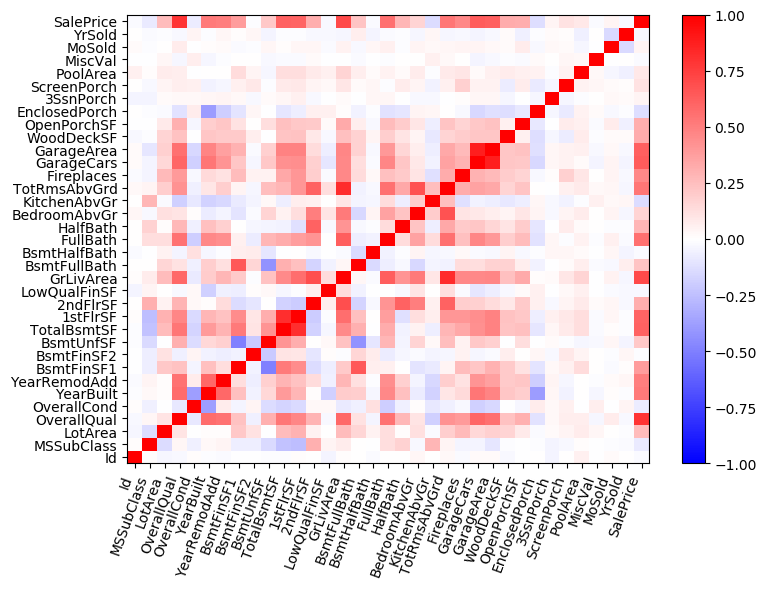

In [8]:
fig = figure("corrmat",figsize=(8,6)) 
ax  = gca()

#opts    = {'cmap':plt.get_cmap("bwr"),'vmin':-1,'vmax':1}
heatmap = pcolor(corrmat,cmap="bwr",vmin=-1,vmax=1)
cbar    = colorbar(heatmap, ax=ax)

# shift location of ticks to center of the bins
ax[:set_xticklabels](col_names, fontsize=10, minor=0, ha="right", rotation=70)
ax[:set_yticklabels](col_names, fontsize=10, minor=0)
ax[:set_xticks]([i-0.5 for i in 1:length(col_names)], minor=false); # set the ticks in the middle of the bin
ax[:set_yticks]([i-0.5 for i in 1:length(col_names)], minor=false); #   so the label goes in the 'right' spot

fig[:canvas][:draw]() 
PyPlot.tight_layout()

The values with the strongest correlations:

In [9]:
# Messing around with loops and confirming the index of sale price
sp_index = -1
for i in enumerate(col_names)
    index = i[1]
    name  = i[2]
    if String(name)=="SalePrice"
        sp_index = index
        println("Sale price is $sp_index ($index)")
    end
end


# Get the more strongly correlated features
sale_price   = corrmat[sp_index,:]
strong_corrs = []
for i in enumerate(sale_price)
    index = i[1]
    value = i[2]
    if value<-0.25 || (value>0.25 && value<1) # exclude `SalePrice` which has corr=1
        push!(strong_corrs,index) 
    end
end

sp_array = sale_price[strong_corrs]
sp_corrnames = col_names[strong_corrs]

Sale price is 35 (35)


17-element Array{Symbol,1}:
 :LotArea          
 :OverallQual      
 :YearBuilt        
 :YearRemodAdd     
 :BsmtFinSF1       
 :TotalBsmtSF      
 Symbol("1stFlrSF")
 Symbol("2ndFlrSF")
 :GrLivArea        
 :FullBath         
 :HalfBath         
 :TotRmsAbvGrd     
 :Fireplaces       
 :GarageCars       
 :GarageArea       
 :WoodDeckSF       
 :OpenPorchSF      

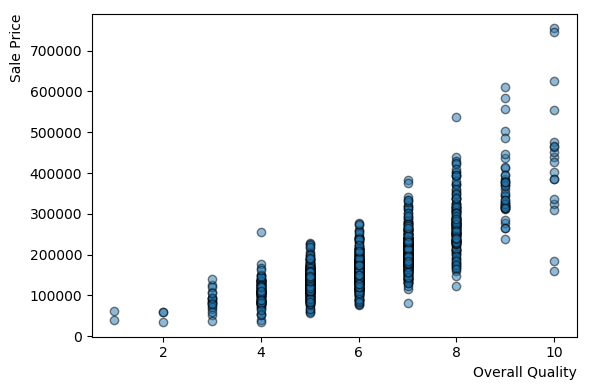

In [164]:
# Let's make a couple more plots for fun: 
# OverallQual vs SalePrice
fig = figure("corrmat",figsize=(6,4)) 
ax  = gca()

scatter(df[:OverallQual],df[:SalePrice],alpha=0.5,edgecolor="k")

xlabel("Overall Quality", position=(1,0), ha="right")
ylabel("Sale Price", position=(0,1), ha="right")

fig[:canvas][:draw]() 
PyPlot.tight_layout()

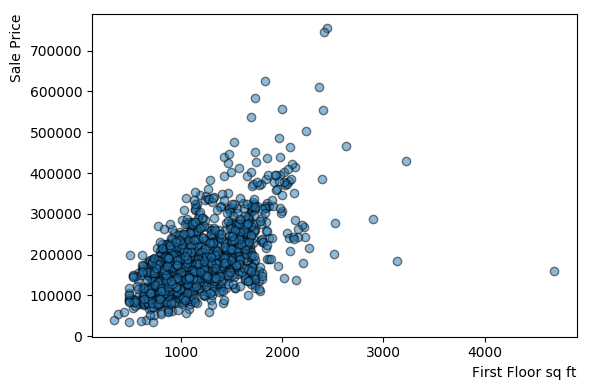

In [178]:
# 1stFlrSF vs SalePrice: Scatter
fig = figure("corrmat",figsize=(6,4)) 
ax  = gca()

scatter(df[Symbol("1stFlrSF")],df[:SalePrice],alpha=0.5,edgecolor="k")
# have to use `Symbol()` to access columns that begin with a number

xlabel("First Floor sq ft", position=(1,0), ha="right")
ylabel("Sale Price", position=(0,1), ha="right")

fig[:canvas][:draw]() 
PyPlot.tight_layout()

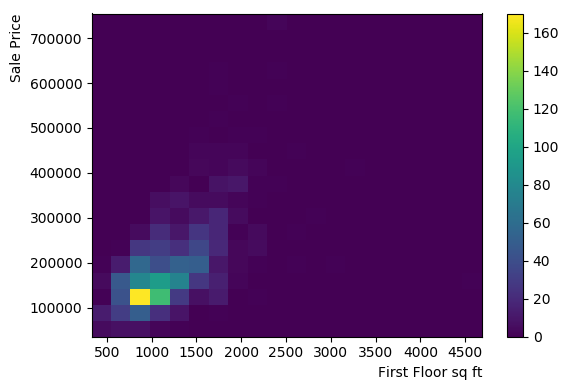

In [193]:
# 1stFlrSF vs SalePrice: 2D Histogram
# https://github.com/gizmaa/Julia_Examples/blob/master/pyplot_histogram.jl
fig = figure("corrmat",figsize=(6,4)) 
ax  = gca()

plt[:hist2d](df[Symbol("1stFlrSF")],df[:SalePrice],bins=20)
plt[:colorbar]()

xlabel("First Floor sq ft", position=(1,0), ha="right")
ylabel("Sale Price", position=(0,1), ha="right")

fig[:canvas][:draw]() 
PyPlot.tight_layout()

With the data accessed, let's now look at using Flux to make some predictions.

Normally I would look into simpler methods first, but because I've already done that using Python, I will just skip it for now and come back to it later if I find time.
[Here](https://github.com/JuliaComputing/JuliaBoxTutorials/blob/master/introductory-tutorials/broader-topics-and-ecosystem/intro-to-julia-for-data-science/2.%20Julia%20for%20Data%20Science%20-%20Algorithms.ipynb) is a great reference for checking non-Flux methods.

And [here](https://github.com/FluxML/model-zoo/blob/master/vision/mnist/mlp.jl) is the MNIST example from Flux.

In [10]:
df_reduced = df[sp_corrnames]

,LotArea,OverallQual,YearBuilt,YearRemodAdd,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF
,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰
1,8450,7,2003,2003,706,856,856,854,1710,2,1,8,0,2,548,0,61
2,9600,6,1976,1976,978,1262,1262,0,1262,2,0,6,1,2,460,298,0
3,11250,7,2001,2002,486,920,920,866,1786,2,1,6,1,2,608,0,42
4,9550,7,1915,1970,216,756,961,756,1717,1,0,7,1,3,642,0,35
5,14260,8,2000,2000,655,1145,1145,1053,2198,2,1,9,1,3,836,192,84
6,14115,5,1993,1995,732,796,796,566,1362,1,1,5,0,2,480,40,30
7,10084,8,2004,2005,1369,1686,1694,0,1694,2,0,7,1,2,636,255,57
8,10382,7,1973,1973,859,1107,1107,983,2090,2,1,7,2,2,484,235,204
9,6120,7,1931,1950,0,952,1022,752,1774,2,0,8,2,2,468,90,0


In [11]:
# Split into testing and training sets
test_train_frac = 0.75
tot_entries     = length(df[:SalePrice])
n_entries       = convert(Int,(round(tot_entries*test_train_frac)))

Xtrain = convert(Array, df_reduced[1:n_entries,:]);
Xtrain = Xtrain'  # transpose for matrix multiplication
Xtest  = convert(Array, df_reduced[n_entries:tot_entries,:]);
Xtest  = Xtest'   # transpose for matrix multiplication
Ytrain = df[1:n_entries,:SalePrice];
Ytest  = df[n_entries:tot_entries,:SalePrice];

In [77]:
Xtrain = collect(Missings.replace(Xtrain,-1));
Ytrain = collect(Missings.replace(Ytrain,-1));
Xtest  = collect(Missings.replace(Xtest,-1));
Ytest  = collect(Missings.replace(Ytest,-1));

In [95]:
zip(Xtrain[:,1],Ytrain)

1095

In [93]:
Xtrain[:,1]

17-element Array{Int64,1}:
 8450
    7
 2003
 2003
  706
  856
  856
  854
 1710
    2
    1
    8
    0
    2
  548
    0
   61

In [87]:
# Build the model 
model = Chain(
  Dense(17, 34, relu),
  Dense(34, 34, relu),
  Dense(34, 1)
)

Chain(Dense(17, 34, NNlib.relu), Dense(34, 34, NNlib.relu), Dense(34, 1))

In [94]:
n_epochs  = 50
loss(x,y) = Flux.mse(model(x), y)
optimizer = ADAM(params(model))
evalcb()  = @show(loss(Xtrain, Ytrain))

evalcb (generic function with 1 method)

In [159]:
# combine the features and targets into single object -- better way to do this with zip() or something?
data = []
for i in 1:length(Ytrain)
    push!(data, (Xtrain[:,i],Ytrain[i]))
end

In [160]:
data

1095-element Array{Any,1}:
 ([8450, 7, 2003, 2003, 706, 856, 856, 854, 1710, 2, 1, 8, 0, 2, 548, 0, 61], 208500)       
 ([9600, 6, 1976, 1976, 978, 1262, 1262, 0, 1262, 2, 0, 6, 1, 2, 460, 298, 0], 181500)      
 ([11250, 7, 2001, 2002, 486, 920, 920, 866, 1786, 2, 1, 6, 1, 2, 608, 0, 42], 223500)      
 ([9550, 7, 1915, 1970, 216, 756, 961, 756, 1717, 1, 0, 7, 1, 3, 642, 0, 35], 140000)       
 ([14260, 8, 2000, 2000, 655, 1145, 1145, 1053, 2198, 2, 1, 9, 1, 3, 836, 192, 84], 250000) 
 ([14115, 5, 1993, 1995, 732, 796, 796, 566, 1362, 1, 1, 5, 0, 2, 480, 40, 30], 143000)     
 ([10084, 8, 2004, 2005, 1369, 1686, 1694, 0, 1694, 2, 0, 7, 1, 2, 636, 255, 57], 307000)   
 ([10382, 7, 1973, 1973, 859, 1107, 1107, 983, 2090, 2, 1, 7, 2, 2, 484, 235, 204], 200000) 
 ([6120, 7, 1931, 1950, 0, 952, 1022, 752, 1774, 2, 0, 8, 2, 2, 468, 90, 0], 129900)        
 ([7420, 5, 1939, 1950, 851, 991, 1077, 0, 1077, 1, 0, 5, 2, 1, 205, 0, 4], 118000)         
 ([11200, 5, 1965, 1965, 906, 1040, 1040, 0

In [98]:
# Train the model!
# - `throttle(f,N)` reduces printouts of function `f` to every `N` seconds
@epochs n_epochs Flux.train!(loss, data, optimizer, cb = throttle(evalcb,1))

┌ Info: Epoch 1
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 4.241818998841111e13 (tracked)


┌ Info: Epoch 2
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.6359757918052748e13 (tracked)
loss(Xtrain, Ytrain) = 1.2101396722341451e13 (tracked)


┌ Info: Epoch 3
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 9.938922747801242e12 (tracked)


┌ Info: Epoch 4
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93
┌ Info: Epoch 5
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 8.993764911636248e12 (tracked)
loss(Xtrain, Ytrain) = 8.747800335557184e12 (tracked)


┌ Info: Epoch 6
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93
┌ Info: Epoch 7
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 8.845747682627857e12 (tracked)
loss(Xtrain, Ytrain) = 9.103597655941195e12 (tracked)


┌ Info: Epoch 8
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 9.435833045840922e12 (tracked)


┌ Info: Epoch 9
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 9.811627222683008e12 (tracked)


┌ Info: Epoch 10
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.0186462658226574e13 (tracked)


┌ Info: Epoch 11
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.0524429753540873e13 (tracked)


┌ Info: Epoch 12
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.0812067083071832e13 (tracked)


┌ Info: Epoch 13
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1061748795486578e13 (tracked)


┌ Info: Epoch 14
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1238654293714955e13 (tracked)


┌ Info: Epoch 15
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1361979651953297e13 (tracked)


┌ Info: Epoch 16
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1485163478009045e13 (tracked)


┌ Info: Epoch 17
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1539867853364055e13 (tracked)


┌ Info: Epoch 18
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93
┌ Info: Epoch 19
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1593080593580248e13 (tracked)


┌ Info: Epoch 20
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1614711267180736e13 (tracked)
loss(Xtrain, Ytrain) = 1.1646709312860424e13 (tracked)


┌ Info: Epoch 21
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93
┌ Info: Epoch 22
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1675433526518287e13 (tracked)
loss(Xtrain, Ytrain) = 1.1690115899951648e13 (tracked)


┌ Info: Epoch 23
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1719368309465414e13 (tracked)


┌ Info: Epoch 24
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1699402995523328e13 (tracked)


┌ Info: Epoch 25
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1730908357780986e13 (tracked)


┌ Info: Epoch 26
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93
┌ Info: Epoch 27
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1712773858569143e13 (tracked)
loss(Xtrain, Ytrain) = 1.1723191193553648e13 (tracked)


┌ Info: Epoch 28
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1765126241837371e13 (tracked)


┌ Info: Epoch 29
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1754853693538502e13 (tracked)


┌ Info: Epoch 30
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1755800256877592e13 (tracked)


┌ Info: Epoch 31
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1726186807509809e13 (tracked)


┌ Info: Epoch 32
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93
┌ Info: Epoch 33
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1784333138174754e13 (tracked)


┌ Info: Epoch 34
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1785321424137756e13 (tracked)
loss(Xtrain, Ytrain) = 1.1774869939136256e13 (tracked)


┌ Info: Epoch 35
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93
┌ Info: Epoch 36
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1778927292670658e13 (tracked)
loss(Xtrain, Ytrain) = 1.180300317936707e13 (tracked)


┌ Info: Epoch 37
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1790832363146223e13 (tracked)


┌ Info: Epoch 38
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1811445168901172e13 (tracked)


┌ Info: Epoch 39
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93
┌ Info: Epoch 40
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1804129546789227e13 (tracked)
loss(Xtrain, Ytrain) = 1.1831822692549113e13 (tracked)


┌ Info: Epoch 41
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.182133877660822e13 (tracked)


┌ Info: Epoch 42
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.184984667439228e13 (tracked)


┌ Info: Epoch 43
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.183681390697494e13 (tracked)


┌ Info: Epoch 44
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1859978877357328e13 (tracked)


┌ Info: Epoch 45
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.184540582435407e13 (tracked)


┌ Info: Epoch 46
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1870474555679648e13 (tracked)


┌ Info: Epoch 47
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.184975538519927e13 (tracked)


┌ Info: Epoch 48
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1854213830909943e13 (tracked)


┌ Info: Epoch 49
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss(Xtrain, Ytrain) = 1.1842723810206666e13 (tracked)


┌ Info: Epoch 50
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


In [99]:
# Results & performance
prediction = convert(Array,model(Xtest).data)

1×366 Array{Float64,2}:
 1.05772e5  1.55056e5  1.02457e5  …  2.14148e5  1.27776e5  1.83974e5

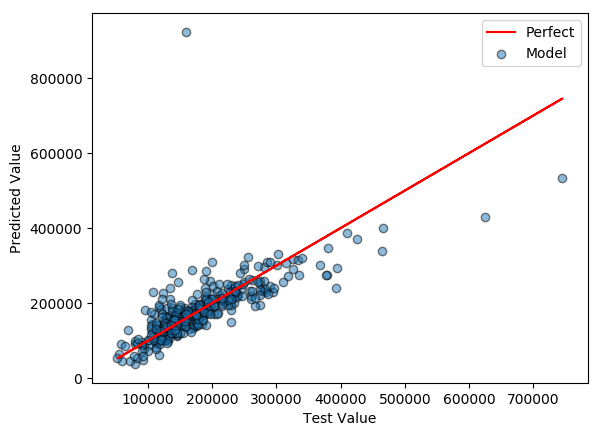

PyObject <matplotlib.legend.Legend object at 0x148ef7be0>

In [100]:
plot(Ytest,Ytest,color="r",label="Perfect")
scatter(Ytest,prediction,alpha=0.5,edgecolor="k",label="Model")
xlabel("Test Value")
ylabel("Predicted Value")
legend()

### Scale the Inputs

From here we can see that the prediction is quite bad.  Let's scale the inputs and try again!

In [101]:
xscale_μ = mean(Xtrain,dims=2)
xscale_σ = std(Xtrain,dims=2)
yscale_μ = mean(Ytrain)
yscale_σ = std(Ytrain)

79728.89168716143

In [102]:
scaler(x,μ,σ) = (x .- μ) ./ σ

scaler (generic function with 1 method)

In [103]:
Xtest_scale  = scaler(Xtest, xscale_μ,xscale_σ);
Xtrain_scale = scaler(Xtrain,xscale_μ,xscale_σ);
Ytest_scale  = scaler(Ytest, yscale_μ,yscale_σ);
Ytrain_scale = scaler(Ytrain,yscale_μ,yscale_σ);

In [118]:
# Build the model 
model_scale = Chain(
    Dense(17, 34, relu),
    Dense(34, 34, relu),
    Dense(34, 1)
)

Chain(Dense(17, 34, NNlib.relu), Dense(34, 34, NNlib.relu), Dense(34, 1))

In [119]:
n_epochs = 50
loss_scale(x,y) = Flux.mse(model_scale(x), y)
optimizer_scale = ADAM(Flux.params(model_scale),0.01)
evalcb_scale()  = @show(loss_scale(Xtrain_scale, Ytrain_scale))

evalcb_scale (generic function with 1 method)

In [120]:
# combine the data into single object -- better way to do this with zip() or something?
data_scale = []
for i in 1:length(Ytrain_scale)
    push!(data_scale, (Xtrain_scale[:,i],Ytrain_scale[i]))
end

In [121]:
# Train!
@epochs n_epochs Flux.train!(loss_scale, data_scale, optimizer_scale, cb = throttle(evalcb_scale,1))

┌ Info: Epoch 1
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 1174.6212887267575 (tracked)
loss_scale(Xtrain_scale, Ytrain_scale) = 1715.5150285865875 (tracked)


┌ Info: Epoch 2
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 1801.0046635387105 (tracked)


┌ Info: Epoch 3
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 1886.2072123230278 (tracked)


┌ Info: Epoch 4
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 1866.7718295144282 (tracked)


┌ Info: Epoch 5
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2124.959718545218 (tracked)


┌ Info: Epoch 6
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2353.274963836864 (tracked)


┌ Info: Epoch 7
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2033.0475693752198 (tracked)


┌ Info: Epoch 8
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2076.574877592134 (tracked)


┌ Info: Epoch 9
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2168.551480946672 (tracked)


┌ Info: Epoch 10
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93
┌ Info: Epoch 11
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2183.320106310665 (tracked)
loss_scale(Xtrain_scale, Ytrain_scale) = 2203.5616842009936 (tracked)


┌ Info: Epoch 12
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93
┌ Info: Epoch 13
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2012.9747891569239 (tracked)
loss_scale(Xtrain_scale, Ytrain_scale) = 2421.8837426663185 (tracked)


┌ Info: Epoch 14
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2196.0155853323186 (tracked)


┌ Info: Epoch 15
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93
┌ Info: Epoch 16
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2207.245620962193 (tracked)
loss_scale(Xtrain_scale, Ytrain_scale) = 2163.149202364651 (tracked)


┌ Info: Epoch 17
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 1892.43468095168 (tracked)


┌ Info: Epoch 18
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2058.5189465691064 (tracked)


┌ Info: Epoch 19
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2041.1637011130892 (tracked)


┌ Info: Epoch 20
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2259.6941167603995 (tracked)


┌ Info: Epoch 21
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2110.0992409829364 (tracked)


┌ Info: Epoch 22
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2215.85038354583 (tracked)


┌ Info: Epoch 23
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 1991.3129306693947 (tracked)


┌ Info: Epoch 24
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2252.814268186381 (tracked)


┌ Info: Epoch 25
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2194.682755848352 (tracked)


┌ Info: Epoch 26
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2154.501569205169 (tracked)


┌ Info: Epoch 27
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 1988.3400524708586 (tracked)


┌ Info: Epoch 28
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2267.0900501808464 (tracked)


┌ Info: Epoch 29
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2222.7268557037637 (tracked)


┌ Info: Epoch 30
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2248.727505719411 (tracked)


┌ Info: Epoch 31
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2132.0930741359475 (tracked)


┌ Info: Epoch 32
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2160.8895783567255 (tracked)


┌ Info: Epoch 33
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2256.3752930186874 (tracked)


┌ Info: Epoch 34
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2199.839004633401 (tracked)


┌ Info: Epoch 35
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2150.6494167539295 (tracked)


┌ Info: Epoch 36
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2216.176001862832 (tracked)


┌ Info: Epoch 37
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2289.0807404256975 (tracked)


┌ Info: Epoch 38
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2295.46007882722 (tracked)


┌ Info: Epoch 39
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2266.4474210924473 (tracked)


┌ Info: Epoch 40
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2258.6089374985672 (tracked)


┌ Info: Epoch 41
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2281.479627123696 (tracked)


┌ Info: Epoch 42
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93
┌ Info: Epoch 43
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2330.277344222279 (tracked)
loss_scale(Xtrain_scale, Ytrain_scale) = 2266.0847006555605 (tracked)


┌ Info: Epoch 44
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2238.2467766527834 (tracked)


┌ Info: Epoch 45
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2297.839440848555 (tracked)


┌ Info: Epoch 46
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2276.480502510083 (tracked)


┌ Info: Epoch 47
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2245.3599517499647 (tracked)


┌ Info: Epoch 48
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2295.1571027844275 (tracked)


┌ Info: Epoch 49
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93
┌ Info: Epoch 50
└ @ Main /Users/demarley/.julia/packages/Flux/UHjNa/src/optimise/train.jl:93


loss_scale(Xtrain_scale, Ytrain_scale) = 2281.5761000380517 (tracked)


In [122]:
# Results & performance
prediction = convert(Array,model_scale(Xtest_scale).data)

1×366 Array{Float64,2}:
 -0.895323  -0.162569  -0.958005  -0.404962  …  0.918529  -0.7869  -0.511285

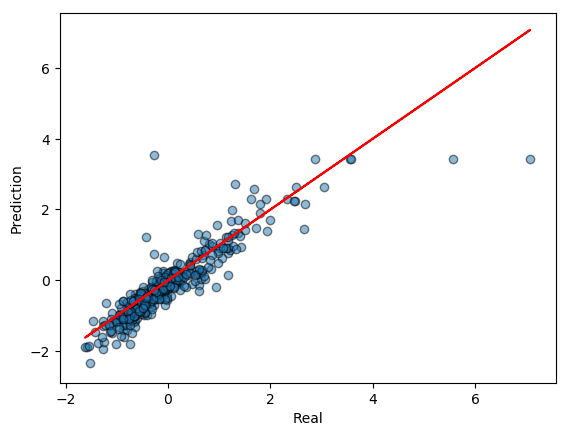

PyObject Text(24.000000000000014, 0.5, 'Prediction')

In [123]:
plot(Ytest_scale,Ytest_scale,color="r")
scatter(Ytest_scale,prediction,alpha=0.5,edgecolor="k")
xlabel("Real")
ylabel("Prediction")

And (finally) we have a prediction that seems reasonable. 
Let's try to quantify this approach using the same function from `scikit-learn` : `explained_variance_score` [GitHub](https://github.com/scikit-learn/scikit-learn/blob/bac89c2/sklearn/metrics/regression.py#L355)

In [157]:
function explained_variance_score(y_true, y_pred)
    # Adapted from scikit-learn implementation (hopefully correctly)
    y_diff_avg = mean(y_true - y_pred)
    numerator  = mean((y_true - y_pred .- y_diff_avg).^2)

    y_true_avg  = mean(y_true)
    denominator = mean((y_true .- y_true_avg).^2)

    output_score = 1 - (numerator / denominator)

    return output_score
end

explained_variance_score (generic function with 1 method)

In [158]:
explained_variance_score(Ytest_scale,prediction')

0.8022143480777216

Assuming my implementation of the `explained_variance_score` isn't too wrong, this looks like a pretty good start for predicting housing prices using Flux!

_NB: Recall that some of the data is numerical, but the `DataFrame` interprets it as a string, e.g., `LotFrontage`.  Thus, there are some features from the 'strong correlation' list in the Python setup that aren't included here.  However, that doesn't seem to affect the performance too much -- at least in this simple example._

From here we could tune the model and try to optimize the performance before submitting results to kaggle.  
For now, I'll leave this as it is and come back to it if I have time.